In [1]:
import numpy as np
from numpy.random import Generator, PCG64
import math
from heateq import Exact, Simulateur
import time
import matplotlib.pyplot as plt

In [2]:
seed = 213731490053398181466621250222036675538
rng = Generator(PCG64(seed))

# Description des simulateurs

On considère l'équation de la chaleur unidimensionnelle vue en cours, et la même distribution de probabilité pour $\mathbf{X}$.
On rappelle que la précision de $\tilde{h}^{(K,Q)}$ est gouvernée par les entiers $K$ et $Q$, et que le coût moyen d'évaluer $\tilde{h}^{(K,Q)}(\mathbf{X})$ est proportionnel à $KQ$.

On définit un simulateur haute fidélité $f = \tilde{h}^{(K=21,Q=60)}$ et un simulateur basse fidélité $g = \tilde{h}^{(K=3,Q=15)}$.

On note $w = c_g / c_f$, où $c_f$ (respectivement, $c_g$) est le coût moyen d'évaluer $f(\mathbf{X})$ (respectivement, $g(\mathbf{X})$).

Dans la suite, on note $Y=f(\mathbf{X})$ et $Z=g(\mathbf{X})$.

In [3]:
# Permet d'obtenir un n-échantillon du vecteur aléatoire d'entrée X
def n_echantillon_X(n):
    return np.vstack(
        (
            rng.uniform(-math.pi, math.pi, (3, n)),
            rng.uniform(0.001, 0.009, (1, n)), 
            rng.uniform(-1., 1., (3, n))
        )
    )

In [4]:
# Simulateurs haute et basse fidélité
f = Simulateur(21, 60)
g = Simulateur(3, 15)

In [5]:
# Espérance exacte de la solution continue
mu_exact = Exact().mu

**Question 1** : Quelle est la valeur attendue de $w$ ? Le vérifier expérimentalement.

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">

On a : $w = c_g / c_f.$

Sachant que les coûts sont proportionnels à $KQ$, on a :
-  $c_f \propto 21 \times 60 = 1260$
-  $c_g \propto 3 \times 15 = 45$

Donc : $w = 1 / 28$.

</div>

In [6]:
# Génération de l'échantillon
ns = 500000
X = n_echantillon_X(ns)

In [ ]:
t1_start = time.process_time()
f(X)
t1_stop = time.process_time()
t2_start = time.process_time()
g(X)
t2_stop = time.process_time()
w_estim = (t2_stop-t2_start) / (t1_stop-t1_start)
print(f"Temps de calcul pour la haute fidélité : {t1_stop-t1_start:.2f} secondes")
print(f"Temps de calcul pour la basse fidélité : {t2_stop-t2_start:.2f} secondes")
print(f"w estimé : {w_estim:.2f}")
print(f"w attendu : {1/28:.2f}")

Temps de calcul pour la haute fidélité : 7.08 secondes
Temps de calcul pour la basse fidélité : 0.20 secondes
w estimé : 0.03
w attendu : 0.03571428571428571


Expérimentalement, la valeurs de $w$ sont autour de $0.03$. ce qui est cohérent avec la valeur $1/28$ théorique.

# Estimateur multifidélité (MF)

On considère un échantillon $\mathcal{X} = \{\mathbf{X}_1, \ldots, \mathbf{X}_N\}$.

On définit un nouvel estimateur multifidélité par 
$\bar{Y}_{n,N}^{\textnormal{mf}}(\alpha) = \bar{Y}_n - \alpha(\bar{Z}_n - \bar{Z}_N)$,
où $0 < n < N$ et

- $\bar{Y}_n = \displaystyle\frac{1}{n} \sum\limits_{i=1}^n f(\mathbf{X}_i)$,
- $\bar{Z}_n = \displaystyle\frac{1}{n} \sum\limits_{i=1}^n g(\mathbf{X}_i)$,
- $\bar{Z}_N = \displaystyle\frac{1}{N} \sum\limits_{i=1}^N g(\mathbf{X}_i)$.

**Question 2** : Montrer que le coût moyen d'évaluation de $\bar{Y}_{n,N}^{\textnormal{mf}}(\alpha)$ est
$c=n(c_f + \eta c_g)$, où $\eta = \dfrac{N}{n}$.
En déduire le nombre d'évaluations haute fidélité équivalentes $\tilde{n}_f = c / c_f$, exprimée en fonction de $\eta$ et $w$.

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">

Pour une estimation de $\bar{Y}^{\text{mf}}_{n, N}(\alpha)$, il faut évaluer :
- $\bar{Y}_{n}$ : $n$ évaluations haute fidélité ($Y$), coûtant chacune $c_f$.
- $\bar{Z}_{N}$ : $N$ évaluations basse fidélité ($Z$), coûtant chacune $c_g$.
- $\bar{Z}_{n}$ : $n < N$ donc on ne fait pas de nouvelle évaluation basse fidélité.

Le coût total est donc :
$$
c = n c_f + N c_g = n(c_f + \eta c_g) \qquad \text{avec } \eta = \frac{N}{n}
$$

On calcule le nombre d’évaluations haute fidélité équivalentes :
$$
\tilde{n}_f = c / c_f = n(1 + \eta w)
$$

</div>

**Question 3** : On note $V_{\tilde{n}_f} = \dfrac{\mathbb{V}[Y]}{\tilde{n}_f}$. Que représente $V_{\tilde{n}_f}$?

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">

$V_{\tilde{n}_f}$ représente la variance d'un estimateur de Monte Carlo utilisant $\tilde{n}_f$ évaluations haute fidélité.

</div>

**Question 4** : Montrer que

- $\mathbb{C}[\bar{Y}_n, \bar{Z}_n - \bar{Z}_N] = \dfrac{N-n}{nN}\mathbb{C}[Y, Z]$
- $\mathbb{V}[\bar{Z}_n - \bar{Z}_N] = \dfrac{N-n}{nN} \mathbb{V}[Z]$.

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">

\begin{align*}
    Cov(\bar{Y}_{n}, \bar{Z}_{n} - \bar{Z}_{N}) &= Cov(\bar{Y}_{n}, \bar{Z}_{n}) - Cov(\bar{Y}_{n}, \bar{Z}_{N}) \quad \text{(linéarité)} \\
    &= \frac{1}{n^2} \sum_{i=1}^{n} \sum_{j=1}^{n} Cov(Y_i, Z_j) - \frac{1}{nN} \sum_{i=1}^{n} \sum_{j=1}^{N} Cov(Y_i, Z_j) \\
    &= \frac{1}{n^2} \sum_{i=1}^{n} Cov(Y_i, Z_i) - \frac{1}{nN} \sum_{i=1}^{n} Cov(Y_i, Z_i) \qquad \text{(car $Cov(Y_i, Z_j) = 0$ si $i \neq j$)} \\
    &= \frac{1}{n} Cov(Y, Z) - \frac{1}{N} Cov(Y, Z) \\
    &= \frac{N - n}{nN} Cov(Y, Z)
\end{align*}

\begin{align*}
    Var(\bar{Z}_{n} - \bar{Z}_{N}) &= Var(\bar{Z}_{n}) + Var(\bar{Z}_{N}) - 2Cov(\bar{Z}_{n}, \bar{Z}_{N}) \\
    &= \frac{1}{n^2} \sum_{i=1}^{n} Var(Z_i) + \frac{1}{N^2} \sum_{i=1}^{N} Var(Z_i) - 2 \frac{1}{nN} \sum_{i=1}^{n} \sum_{j=1}^{N} Cov(Z_i, Z_j) \\
    &= \frac{1}{n^2} nVar(Z) + \frac{1}{N^2} NVar(Z) - 2 \frac{1}{nN} \sum_{i=1}^{n} Cov(Z_i, Z_i) \qquad \text{(car $Cov(Z_i, Z_j) = 0$ si $i \neq j$)} \\
    &= \frac{1}{n} Var(Z) + \frac{1}{N} Var(Z) - 2 \frac{1}{nN} nCov(Z, Z) \\
    &= \frac{1}{n} Var(Z) - \frac{1}{N} Var(Z) \\
    &= \frac{N - n}{nN} Var(Z)
\end{align*}

</div>

**Question 5** : En déduire que la valeur optimale $\alpha^*$ de $\alpha$ qui minimise $\mathbb{V}[\bar{Y}_{n,N}^{\textnormal{mf}}(\alpha)]$, est
$$\alpha^*=\dfrac{\mathbb{C}[Y, Z]}{\mathbb{V}[Z]}$$
et que la variance minimale est alors
$$\mathbb{V}[\bar{Y}_{n,N}^{\textnormal{mf}}(\alpha^*)]
= \dfrac{\mathbb{V}[Y]}{n}\left[1 - \dfrac{N-n}{N} \rho^2 \right]
= V_{\tilde{n}_f}(1+\eta w)\left[1 - \left(1 - \dfrac{1}{\eta}\right) \rho^2 \right]$$
où $\rho$ est le coefficient de corrélation de Pearson entre $Y$ et $Z$.

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">

On a :
\begin{align*}
    Var(\bar{Y}^{\text{mf}}_{n, N}(\alpha)) &= Var(\bar{Y}_{n} - \alpha (\bar{Z}_{n} - \bar{Z}_{N})) \\
    &= Var(\bar{Y}_{n}) + \alpha^2 Var(\bar{Z}_{n} - \bar{Z}_{N}) - 2\alpha Cov(\bar{Y}_{n}, \bar{Z}_{n} - \bar{Z}_{N}) \\
    &= \frac{1}{n} Var(Y) + \alpha^2 \frac{N - n}{nN} Var(Z) - 2\alpha \frac{N - n}{nN} Cov(Y, Z)
\end{align*}

On dérive par rapport à $\alpha$ :
\begin{align*}
    \frac{d}{d\alpha} Var(\bar{Y}^{\text{mf}}_{n, N}(\alpha)) &= 2\alpha \frac{N - n}{nN} Var(Z) - 2 \frac{N - n}{nN} Cov(Y, Z) \\
    &= 2 \frac{N - n}{nN} \left( \alpha Var(Z) - Cov(Y, Z) \right)
\end{align*}

Le minimum est donc atteint pour :
$$
\alpha^* = \frac{Cov(Y, Z)}{Var(Z)}
$$

On calcule $Var(\bar{Y}^{\text{mf}}_{n, N}(\alpha^*))$ :
\begin{align*}
    Var(\bar{Y}^{\text{mf}}_{n, N}(\alpha^*)) &= \frac{1}{n} Var(Y) + \left( \frac{Cov(Y, Z)}{Var(Z)} \right)^2 \frac{N - n}{nN} Var(Z) - 2\frac{Cov(Y, Z)}{Var(Z)} \frac{N - n}{nN} Cov(Y, Z) \\
    &= \frac{1}{n} Var(Y) + \frac{(Cov(Y, Z))^2}{Var(Z)} \frac{N - n}{nN} Var(Z) - 2\frac{(Cov(Y, Z))^2}{Var(Z)} \frac{N - n}{nN} \\
    &= \frac{Var(Y)}{n}\left[1 - \frac{N - n}{nN} \rho^2 \right] \qquad \text{avec } \rho^2 = \frac{(Cov(Y, Z))^2}{Var(Y)Var(Z)} \\
    &= \frac{Var(Y)}{n(1 + \eta w)}(1 + \eta w) \left[1 - \left(1 - \frac{1}{\eta} \right) \rho^2 \right] \\
    &= V_{\tilde{n}_f}(1 + \eta w) \left[1 - \left(1 - \frac{1}{\eta} \right) \rho^2 \right]
\end{align*}

</div>

**Question 6** : Comparer l'expression de $\mathbb{V}[\bar{Y}_{n,N}^{\textnormal{mf}}(\alpha^*)]$ à celle de $\mathbb{V}[\bar{Y}_{n,N}^{\textnormal{acv}}(\alpha^*)]$ vue en cours. 
En déduire, **sans faire de calculs** (uniquement à partir du cours), que la valeur optimale $\eta^*$ de $\eta$ qui minimise $\mathbb{V}[\bar{Y}_{n,N}^{\textnormal{mf}}(\alpha^*)]$ est
$$\eta^* = \sqrt{\dfrac{\rho^2}{w(1-\rho^2)}}$$
et que, pour un budget $\tilde{n}_f$ donné, l'estimateur MF optimal est
$$\bar{Y}_{n^*,N^*}^{\textnormal{mf}}(\alpha^*) = \bar{Y}_{n^*} - \alpha^*(\bar{Z}_{n^*} - \bar{Z}_{N^*})$$
où $n^* = \dfrac{\tilde{n}_f}{1 + \eta^* w}$ et $N^* = \eta^* n^*$.

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">

Dans le cours, on a vu que l'estimateur ACV est :
$$
\bar{Y}^{\text{ACV}}_{n, N}(\alpha^*) = V_{\tilde{n}_f}(1 + \tau w) \left[1 - \left(1 - \frac{1}{\tau} \right) \rho^2 \right]
$$
où $\tau = 1 + \frac{N}{n}$.

Les formules sont donc identiques (on remplace $\eta$ par $\tau$).
D'après le cours, la valeur de $\tau$ optimale, $\tau^*$, est :
$$
\tau^* = \sqrt{\dfrac{\rho^2}{w(1 - \rho^2)}}
$$

Donc $\eta^* = \tau^*$.  

On a : $\tilde{n}_f = n(1 + \eta w) \Rightarrow n^* = \dfrac{\tilde{n}_f}{1 + \eta^* w}$ et $\eta = \dfrac{N}{n} \Rightarrow N^* = n^* \eta^*$.

</div>

**Question 7** : Déduire du cours (toujours sans faire de calculs) que
$$\beta^{\textnormal{mf}} = \dfrac{\mathbb{V}[\bar{Y}_{n^*,N^*}^{\textnormal{mf}}(\alpha^*)]}{V_{\tilde{n}_f}}
= (1+\eta^* w)^2 (1 - \rho^2).$$

Quelles conclusions peut-on tirer sur les estimateurs MF et ACV optimaux ?

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">

Dans le cours, on a:
$$
\beta(\tau) = (1 + \tau w)(1 - (1 - \frac{1}{\tau}) \rho^2)
$$

et 
$$
\beta(\tau^*) = (1 + \tau^* w)^2 (1 - \rho^2)
$$
On a donc $\beta^{\text{mf}} = \beta(\tau^*)$.

Les deux formules sont identiques, on remplace $\tau$ par $\eta$. \\

Les estimateurs MF et ACV optimaux ont des performances équivalentes, mais l'estimateur MF a un coût d'évaluation plus faible (coût de l'estimateur ACV : $c = n (1 + (1 + \eta)w)$). \\

Le facteur $(1 - \rho^2)$ dans $\beta$ montre que la réduction de variance est d'autant plus importante que la corrélation entre les simulateurs est faible. \\

</div>

# Expérience pilote

**Question 8** : Estimer $\alpha^*$, $\eta^*$ et $\rho^2$ à l'aide de `p = 10000` échantillons pilotes.

In [10]:
p = 10000 # échantillons pilotes
X = n_echantillon_X(p)

In [11]:
# Question 8 :Estimer alpha_star, eta_star et rho_2

Y = f(X)
Z = g(X)
cov_matrix_YZ = np.cov(Y, Z)
cov_YZ = cov_matrix_YZ[0,1]
var_Y = cov_matrix_YZ[0,0]
var_Z = cov_matrix_YZ[1,1]

w = 1/28

alpha_star = cov_YZ / var_Z

rho_2 = cov_YZ**2 / (var_Y * var_Z)

eta_star = math.sqrt(rho_2 / (w * (1 - rho_2)))


print("alpha_star :", alpha_star)
print("eta_star :", eta_star)
print("rho_2 :", rho_2)

alpha_star : 1.0072832884557006
eta_star : 38.01133544990836
rho_2 : 0.9809893885693431


**Question 9** : En déduire une estimation de $\beta^{\textnormal{mf}}=(1+\eta^* w)^2(1-\rho^2)$.

In [12]:
# Question 9 : En déduire une estimation de betamf

beta_mf_estim = (1 + eta_star * w)**2 * (1 - rho_2)

print("beta_mf :", beta_mf_estim)

beta_mf : 0.10566157017945912


# Étude numérique de l'estimateur MF

**Question 10** : Utiliser la valeur de $\alpha^*$ estimée précédemment (avec les échantillons pilotes) pour contruire un estimateur MF de l'espérance de $Y$.
Faire `nr = 1000` répétitions pour des budgets (en termes de nombre d'évaluations haute fidélité équivalentes) $\tilde{n}_f \in \{5; 10; 20; 50; 100; 200; 500; 1000\}$.

In [13]:
nr = 1000
budgets = [5, 10, 20, 50, 100, 200, 500, 1000]

In [14]:
# Y_mc -> Estimateur de Monte Carlo
# Y_mf -> Estimateur multifidélité


esp_Y_mc_mean = []
std_Y_mc_mean = []
REQM_Y_mc = []
esp_Y_mf = []
std_Y_mf = []
REQM_Y_mf = []

beta_mf = []



for n_tilde in budgets:
    Y_mc = np.zeros(nr)
    Y_mf = np.zeros(nr)
    REQM_Y_mc_ = np.zeros(nr)
    REQM_Y_mf_ = np.zeros(nr)

    n_star = int(math.floor(n_tilde / (1 + eta_star * w)))
    N_star = int(math.floor(eta_star * n_star))

    for ir in range(nr):
        # Échantillonnage des données
        X_n_tilde = n_echantillon_X(n_tilde)
        X_n_star = n_echantillon_X(n_star)
        X_N_star = n_echantillon_X(N_star)
        
        Y_n_tilde = f(X_n_tilde)
        Y_n_star = f(X_n_star)

        Z_n_star = g(X_n_star)
        Z_N_star = g(X_N_star)

        # Estimateur Monte Carlo
        Y_mc_ = Y_n_tilde.mean()

        # Construction de l'estimateur MF
        Y_mf_ = Y_n_star.mean() - alpha_star * (Z_n_star.mean() - Z_N_star.mean())

        Y_mc[ir] = Y_mc_
        Y_mf[ir] = Y_mf_

        # Calcul des erreurs quadratiques moyennes
        REQM_Y_mc_[ir] = np.sqrt((Y_mc_ - mu_exact) ** 2)
        REQM_Y_mf_[ir] = np.sqrt((Y_mf_ - mu_exact) ** 2)

    # Moyennes et écarts-types des estimateurs
    esp_Y_mc_mean.append(np.mean(Y_mc))
    std_Y_mc_mean.append(np.std(Y_mc))
    REQM_Y_mc.append(np.mean(REQM_Y_mc_))
    
    esp_Y_mf.append(np.mean(Y_mf))
    std_Y_mf.append(np.std(Y_mf))
    REQM_Y_mf.append(np.mean(REQM_Y_mf_))

    # Calcul de beta_mf
    beta_value = np.var(Y_mf) / np.var(Y_mc)
    beta_mf.append(beta_value)


**Question 11** : Pour chaque budget, estimer le rapport de variance $\beta^{\textnormal{mf}}$ à budget équivalent entre l'estimateur MF et l'estimateur Monte Carlo classique (haute fidélité). Ces estimations sont-elles conformes à la valeur de $\beta^{\textnormal{mf}}$ estimée précédemment (dans l'expérience pilote) ?

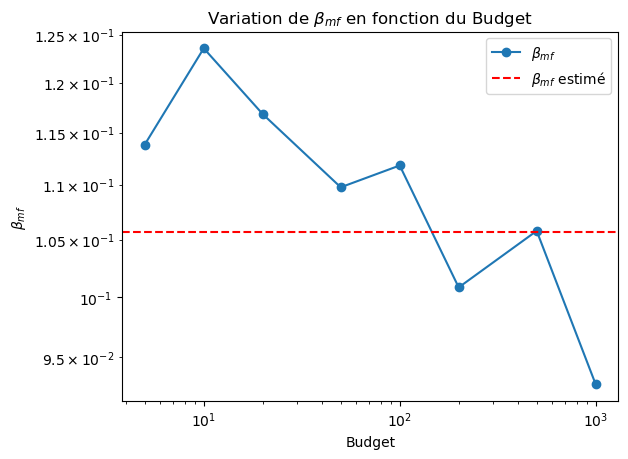

In [15]:
# Question 11 Comparaison du rapport de variance beta_mf

plt.loglog(budgets, beta_mf, marker='o', linestyle='-', label=r'$\beta_{mf}$')
plt.axhline(y=beta_mf_estim, color='r', linestyle='--', label=r'$\beta_{mf}$ estimé')

plt.xlabel('Budget')
plt.ylabel(r'$\beta_{mf}$')
plt.title(r'Variation de $\beta_{mf}$ en fonction du Budget')
plt.legend()
plt.show()

In [16]:
print(f"beta_mf : {beta_mf}")
print(f"beta_mf estimé : {beta_mf_estim}")

beta_mf : [0.11384271093858539, 0.12355306343630736, 0.1168254573217494, 0.10977494059168537, 0.11182976098117549, 0.10081017808168276, 0.10577625616054138, 0.09283059815545407]
beta_mf estimé : 0.10566157017945912


**Question 12** : Tracer l'espérance et l'écart-type (sous forme de barres d'erreur) des estimateurs MF et Monte Carlo (haute fidélité) à budget équivalent en fonction de $\tilde{n}_f$.
Sur un autre graphe (en échelle log-log), tracer l'évolution de la REQM (par rapport à l'espérance exacte du problème continu, `mu_exact`) des estimateurs en fonction de $\tilde{n}_f$.

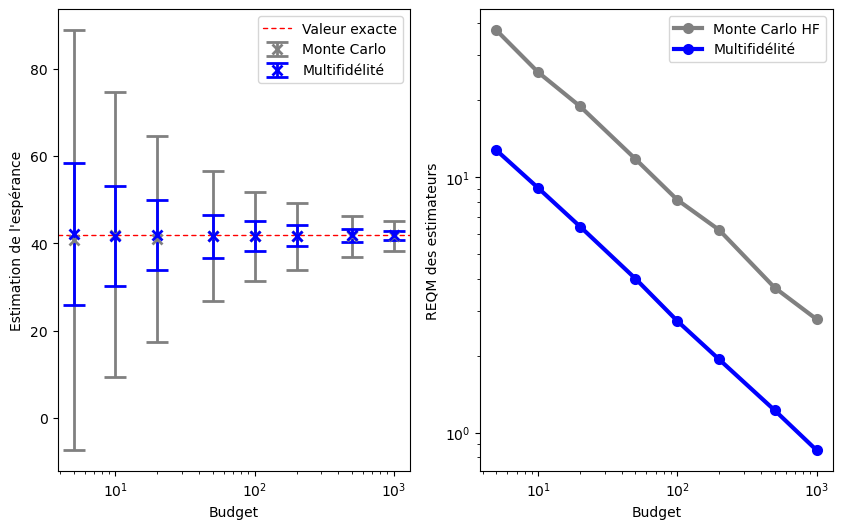

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

# Graphe de l'estimation de l'espérance avec barres d'erreur
axs[0].errorbar(
    budgets, esp_Y_mc_mean, std_Y_mc_mean,
    fmt='x', color='gray', lw=2, capsize=8, markeredgewidth=2, markersize=7,
    label='Monte Carlo'
)
axs[0].errorbar(
    budgets, esp_Y_mf, std_Y_mf,
    fmt='xb', lw=2, capsize=8, markeredgewidth=2, markersize=7,
    label='Multifidélité'
)
axs[0].axhline(y=mu_exact, linestyle="--", dashes=(3, 3), linewidth=1, color="red", dash_capstyle="round",label=r'Valeur exacte')
axs[0].set_xscale('log')
axs[0].set_xlabel('Budget')
axs[0].set_ylabel("Estimation de l'espérance")
axs[0].legend()

# Graphe du REQM des estimateurs
axs[1].plot(budgets, REQM_Y_mc, 'o-', color='gray', lw=3, markeredgewidth=2, markersize=6, label='Monte Carlo HF')
axs[1].plot(budgets, REQM_Y_mf, 'ob-', lw=3, markeredgewidth=2, markersize=6, label='Multifidélité')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('Budget')
axs[1].set_ylabel('REQM des estimateurs')
axs[1].legend()

plt.show()


<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">

Pour le premier graphique, la variance de l'estimateur MF est beaucoup plus faible que celle de l'estimateur haute fidélité à même budget, de plus les espérances des deux estimateurs sont assez proches de la valeur exacte, les deux estimateurs ne sont pas biaisés.

Pour le second graphique, les REQM de deux estimateurs ont des allures similaires. Les deux courbes sont translatées d'environ 0.3 ce qui correspond bien à la théorie, on a $\sqrt{\beta^{\textnormal{mf}}} \approx 0.3$.

</div>